Dataset is download from: https://huggingface.co/harpomaxx/dga-detector

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [1]:
# !pip install tldextract
# !pip install pandas
# !pip install nltk 
# !pip install matplotlib
# !pip install torch
!pip install scikit-learn

In [2]:
import pandas as pd
from nltk import ngrams
import tldextract as tld
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import numpy as np


In [3]:
path = "dataset/dga1.0.csv"
df = pd.read_csv(path)
df.head()

,default/domain,default/label,default/class
0,b'vashikarana.net',b'normal.alexa',0
1,b'vashikaranandblackmagicforlove.blogspot.in',b'normal.alexa',0
2,b'vashikaranastrologerguru.com',b'normal.alexa',0
3,b'vashikaranblackmagicindia.com',b'normal.alexa',0
4,b'vashikarangod.com',b'normal.alexa',0


In [4]:
print("The shape of df: ",df.shape)
print(" there are " + str(df[df['default/class'] == 0].shape[0]) + " records of 0 case")
print(" there are " + str(df[df['default/class'] == 1].shape[0]) + " records of 1 case")
print("category of labels: \n",pd.unique(df['default/label']))

The shape of df:  (2918496, 3)
 there are 1003161 records of 0 case
 there are 1915335 records of 1 case
category of labels: 
 ["b'normal.alexa'" "b'dga.pykspa'" "b'dga.necurs'" "b'dga.ramnit'"
 "b'dga.symmi'" "b'dga.ranbyus'" "b'dga.qakbot'" "b'dga.nymaim'"
 "b'dga.kraken'" "b'dga.rovnix'" "b'dga.gameover'" "b'dga.pushdo'"
 "b'dga.locky'" "b'dga.shiotob/urlzone/bebloh'" "b'dga.cryptolocker'"
 "b'dga.virut'" "b'dga.post'" "b'dga.shifu'" "b'dga.hesperbot'"
 "b'dga.dyre'" "b'dga.banjori'" "b'dga.bedep'" "b'dga.tinba'"
 "b'dga.dircrypt'" "b'dga.fobber'" "b'dga.murofet'" "b'dga.geodo'"
 "b'dga.p2p'" "b'dga.qadars'" "b'dga.conficker'" "b'dga.vawtrak'"
 "b'dga.pykspa_v2_real'" "b'dga.chinad'" "b'dga.pykspa_v2_fake'"
 "b'dga.tempedreve'" "b'dga.simda'" "b'dga.matsnu'" "b'dga.suppobox'"
 "b'dga.cryptowall'" "b'dga.proslikefan'" "b'dga.pykspa_v1'"
 "b'dga.corebot'" "b'dga.ramdo'" "b'dga.madmax'" "b'dga.volatile'"
 "b'dga.goz'" "b'dga.newgoz'" "b'dga.bamital'" "b'dga.padcrypt'"
 "b'dga.sisron'" 

In [5]:
def clean_domain(sentence):
    if isinstance(sentence, bytes):
        sentence = sentence.decode('utf-8')
    if sentence.startswith("b'") and sentence.endswith("'"):
        sentence = sentence[2:-1]
    return tld.extract(sentence).domain

def clean_label(label):
    if isinstance(label, bytes):
        label = label.decode('utf-8')
    if label.startswith("b'") and label.endswith("'"):
        label = label[2:-1]
    return label

def generate_1grams(text):
    return list(ngrams(text, 1))

In [6]:
sentence = df.iloc[:]['default/domain']
df['claened_domain'] = df['default/domain'].apply(clean_domain)
df['cleaned_label'] = df['default/label'].apply(clean_label)

In [7]:
#popular doamin
print(df[df['default/domain'] == "b'google.com'"].index)
print(df[df['default/domain'] == "b'amazon.com'"].index)
print(df[df['default/domain'] == "b'youtube.com'"].index)
print(df[df['default/domain'] == "b'reddit.com'"].index)
print(df[df['default/domain'] == "b'4chan.com'"].index)

Index([1396701], dtype='int64')
Index([813985], dtype='int64')
Index([225162], dtype='int64')
Index([2254564], dtype='int64')
Index([726771], dtype='int64')


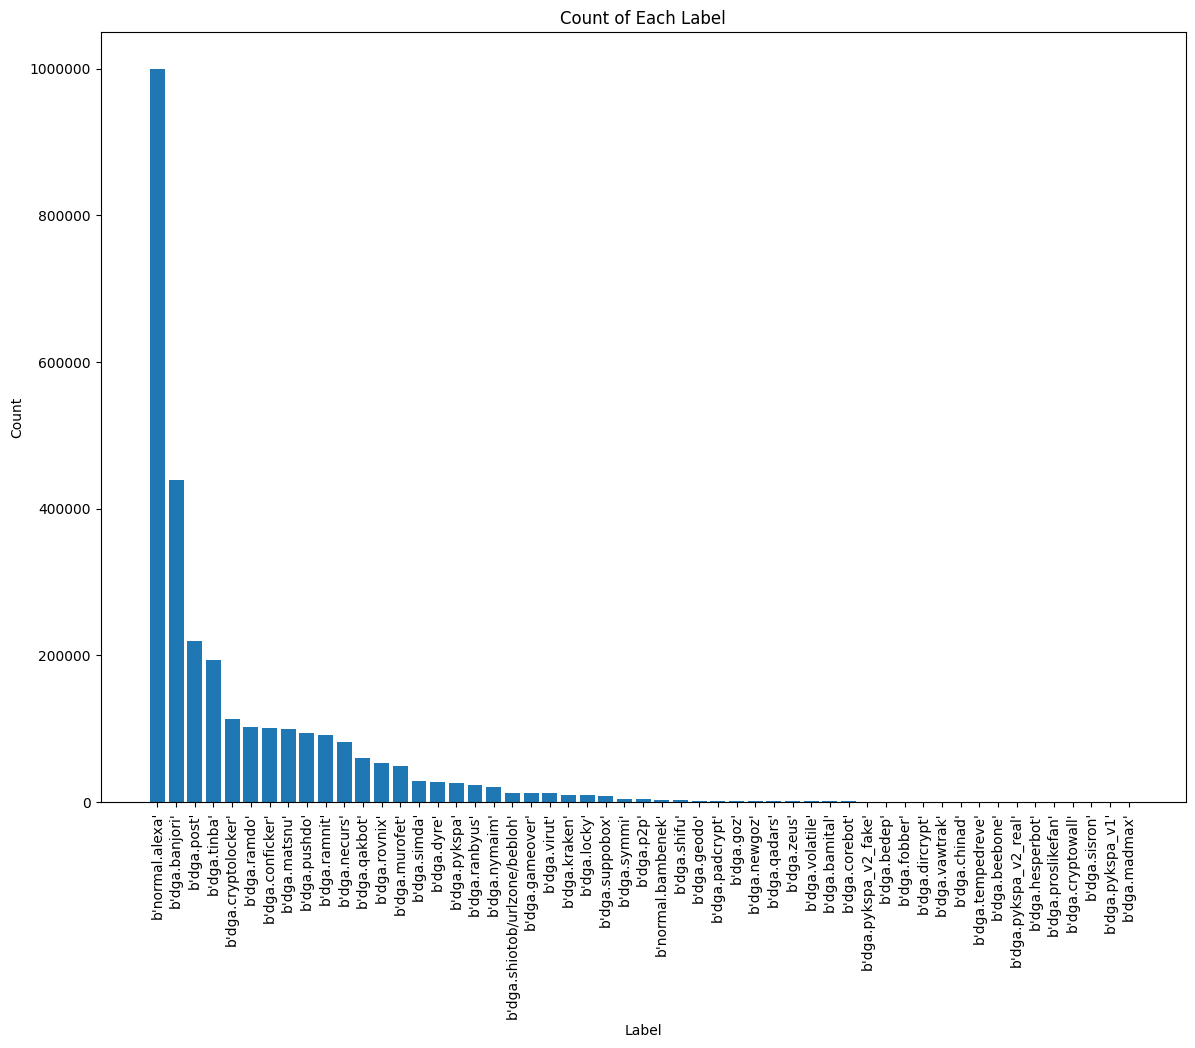

default/label
b'normal.alexa'                  999993
b'dga.banjori'                   439218
b'dga.post'                      220000
b'dga.tinba'                     193912
b'dga.cryptolocker'              112809
b'dga.ramdo'                     102000
b'dga.conficker'                 100496
b'dga.matsnu'                    100127
b'dga.pushdo'                     94278
b'dga.ramnit'                     91978
b'dga.necurs'                     81920
b'dga.qakbot'                     60000
b'dga.rovnix'                     53632
b'dga.murofet'                    49199
b'dga.simda'                      28389
b'dga.dyre'                       26993
b'dga.pykspa'                     25727
b'dga.ranbyus'                    23167
b'dga.nymaim'                     20225
b'dga.shiotob/urlzone/bebloh'     12521
b'dga.gameover'                   12000
b'dga.virut'                      11994
b'dga.kraken'                      9660
b'dga.locky'                       9028
b'dga.suppobox'           

In [8]:
# statistic over all kinds of labels
label_counts = df['default/label'].value_counts()
plt.figure(figsize=(14, 10))
plt.bar(label_counts.index, label_counts.values)
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
print(label_counts)

In [35]:
# sample_df = df.groupby('cleaned_label').apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)
sample_df = df.sample(frac=0.2).reset_index(drop=True)
print(sample_df)

                          default/domain    default/label  default/class  \
0                b'rbpubbriddxfojuc.com'    b'dga.ramnit'              1   
1       b'noiseislandleavehabittune.com'    b'dga.matsnu'              1   
2          b'kettlercapitalsiceplex.com'  b'normal.alexa'              0   
3                    b'kdffcdlmcnbn.com'     b'dga.tinba'              1   
4               b'submitdirectory.co.uk'  b'normal.alexa'              0   
...                                  ...              ...            ...   
583694                   b'ec-store.net'  b'normal.alexa'              0   
583695                  b'albemarle.com'  b'normal.alexa'              0   
583696    b'rvqgsatformalisticirekb.com'   b'dga.banjori'              1   
583697                b'tnqmepictom.com'   b'dga.banjori'              1   
583698         b'nuaa8n1oroggq2g4bg.net'    b'dga.rovnix'              1   

                   claened_domain cleaned_label  
0                rbpubbriddxfojuc    

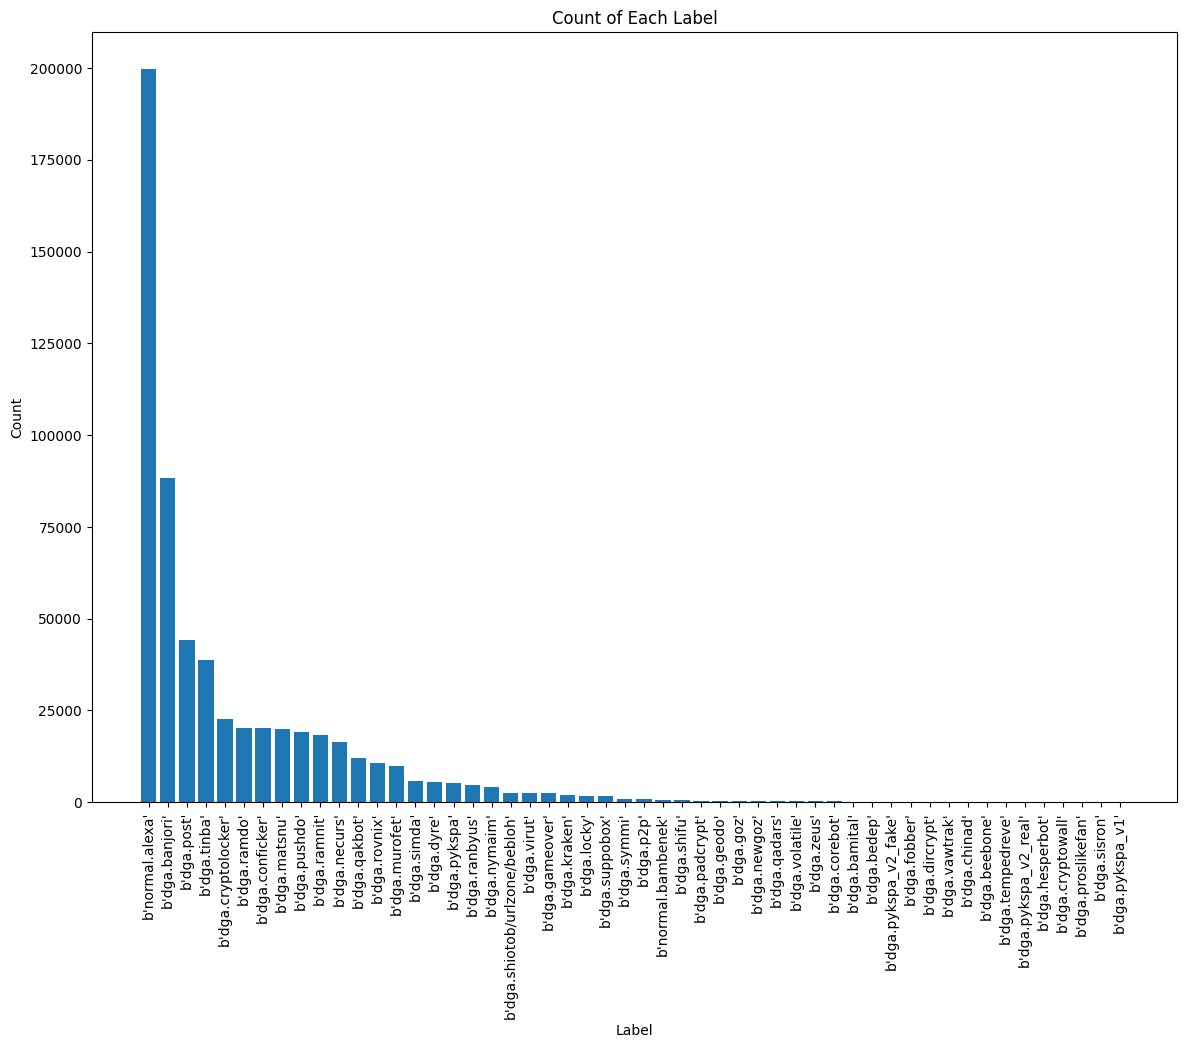

default/label
b'normal.alexa'                  199787
b'dga.banjori'                    88230
b'dga.post'                       44158
b'dga.tinba'                      38632
b'dga.cryptolocker'               22548
b'dga.ramdo'                      20308
b'dga.conficker'                  20059
b'dga.matsnu'                     19804
b'dga.pushdo'                     19032
b'dga.ramnit'                     18346
b'dga.necurs'                     16337
b'dga.qakbot'                     12091
b'dga.rovnix'                     10629
b'dga.murofet'                     9878
b'dga.simda'                       5655
b'dga.dyre'                        5374
b'dga.pykspa'                      5178
b'dga.ranbyus'                     4623
b'dga.nymaim'                      4059
b'dga.shiotob/urlzone/bebloh'      2565
b'dga.virut'                       2467
b'dga.gameover'                    2395
b'dga.kraken'                      1972
b'dga.locky'                       1757
b'dga.suppobox'           

In [36]:
# statistic over all kinds of labels
label_counts = sample_df['default/label'].value_counts()

plt.figure(figsize=(14, 10))
plt.bar(label_counts.index, label_counts.values)
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
print(label_counts)

In [37]:
sample_df['1grams'] = sample_df['claened_domain'].apply(generate_1grams)

In [38]:
print(sample_df.head())
print(sample_df.shape)

                     default/domain    default/label  default/class  \
0           b'rbpubbriddxfojuc.com'    b'dga.ramnit'              1   
1  b'noiseislandleavehabittune.com'    b'dga.matsnu'              1   
2     b'kettlercapitalsiceplex.com'  b'normal.alexa'              0   
3               b'kdffcdlmcnbn.com'     b'dga.tinba'              1   
4          b'submitdirectory.co.uk'  b'normal.alexa'              0   

              claened_domain cleaned_label  \
0           rbpubbriddxfojuc    dga.ramnit   
1  noiseislandleavehabittune    dga.matsnu   
2     kettlercapitalsiceplex  normal.alexa   
3               kdffcdlmcnbn     dga.tinba   
4            submitdirectory  normal.alexa   

                                              1grams  
0  [(r,), (b,), (p,), (u,), (b,), (b,), (r,), (i,...  
1  [(n,), (o,), (i,), (s,), (e,), (i,), (s,), (l,...  
2  [(k,), (e,), (t,), (t,), (l,), (e,), (r,), (c,...  
3  [(k,), (d,), (f,), (f,), (c,), (d,), (l,), (m,...  
4  [(s,), (u,), (b,),

In [39]:
# word embedding layer
class InputEmbeddings(nn.Module):

  def __init__(self, d_model:int, vocab_size: int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    # the embedding model we will use
    self.embedding = nn.Embedding(vocab_size, d_model)

  # when there is any data inputted to the instance it will call this function.
  def forward(self,x):
    return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    # Create a matrix of shape(seq_len, d_model)
    pe = torch.zeros(seq_len, d_model) # torch.zeors create a tensor that all zero
    # Create a vector of shape
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (Seq_Len, 1)
    # this is quite different from the forumla I know
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    # Apply the sin encoding to even number
    pe[:, 0::2] = torch.sin(position * div_term)
    # Apply the cos encoding to odd number
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)

    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

class LayerNormalization(nn.Module):
  def __init__(self, eps:float = 10**-6):
    super().__init__()
    self.eps = eps  # this is a constant
    self.alpha = nn.Parameter(torch.ones(1)) # nn.Parameter means it is tranable
    self.bias = nn.Parameter(torch.zeros(1))
  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    std = x.std(dim= -1, keepdim= True)
    return self.alpha * (x - mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int, d_ff:int, dropout:float) -> None:
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff) # weighting1 and bias1
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model) # weighting2 and bias2

  def forward(self, x):
    #so we first let the input x go throgh linear_1, then a relu activation function, moreover dropout and go linear_2.
    return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class MultiHeadAttentionBlock(nn.Module):

  def __init__(self, d_model: int, h: int, dropout: float) ->None:
    super().__init__()
    self.d_model = d_model
    self.h = h
    assert d_model % h == 0, "d_model need to be divisible by h"

    self.d_k = d_model // h
    self.w_q = nn.Linear(d_model, d_model) # wq
    self.w_k = nn.Linear(d_model, d_model) # wk
    self.w_v = nn.Linear(d_model, d_model) # wv

    self.w_o = nn.Linear(d_model, d_model) # wo
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
    d_k = query.shape[-1]

    # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
    attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        # mask size
        attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

    attention_scores = attention_scores.softmax(dim=-1)

    if dropout is not None:
        attention_scores = dropout(attention_scores)

    return (attention_scores @ value), attention_scores


  def forward(self, q, k, v, mask):
    # input the word to weighting layer
    query = self.w_q(q)
    key = self.w_k(k)
    value = self.w_v(v)

    # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
    key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

    # matching the attention score diamention
    if mask is not None:
        mask = mask.unsqueeze(1).unsqueeze(1)  # adding 2 new diamention in order to let it fit with the attention score

    x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

    # (batch, h, seq_len, d_k) --> (batch, seq_len, d_model)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

    return self.w_o(x)


class ResidualConnection(nn.Module):

  def __init__(self, dropout: float) -> None:
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

class EncoderBlock(nn.Module):

  def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self, x, src_mask):
    # in the init method it construct 2 layers of #residual_connections
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
    x = self.residual_connections[1](x, self.feed_forward_block)
    return x

class Encoder(nn.Module):

  def __init__(self, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

class DecoderBlock(nn.Module):
  def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
    x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
    x = self.residual_connections[2](x, self.feed_forward_block)
    return x

class Decoder(nn.Module):

  def __init__(self, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, encoder_output, src_mask, tgt_mask):
      for layer in self.layers:
        x = layer(x, encoder_output, src_mask, tgt_mask)
      return self.norm(x)

class ProjectionLayer(nn.Module):

  def __init__(self, d_model: int, vocab_size: int) -> None:
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
    return torch.log_softmax(self.proj(x), dim = -1)

class Transformer(nn.Module):

  def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self, src, src_mask):
    src = self.src_embed(src)
    src = self.src_pos(src)
    return self.encoder(src, src_mask)

  def decode(self, encoder_output, src_mask, tgt, tgt_mask):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

  def project(self, x):
    return self.projection_layer(x)

def build_transformer(src_vocab_size:int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:
  # Create embedding layers
  src_embed = InputEmbeddings(d_model, src_vocab_size)
  tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

  # Create the positional encoding layers
  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  # Create the encoder blocks
  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
    encoder_blocks.append(encoder_block)

  # Create the decoder blocks
  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
    decoder_blocks.append(decoder_block)

  # Create the encoder and the decoder
  encoder = Encoder(nn.ModuleList(encoder_blocks))
  decoder = Decoder(nn.ModuleList(decoder_blocks))

  # Create the projection layer
  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  # Create the transformer
  transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

  # Initialize the parameters
  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer

# Things above is just copy from the internet, the model below is the encoder we are going to use.
# d_model is the diamention of model/ N is the number of encoder
class DGA_Dector(nn.Module):
  def __init__(self, vocab_size: int, d_model: int, N: int, h: int, d_ff: int, max_len: int, num_classes: int = 1, dropout: float = 0.1):
    super().__init__()

    # Embedding layer
    self.src_embed = InputEmbeddings(d_model, vocab_size)

    # Positional encoding
    self.src_pos = PositionalEncoding(d_model, max_len, dropout)

    # Create encoder blocks
    encoder_blocks = []
    for _ in range(N):
        self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Encoder
    self.encoder = Encoder(nn.ModuleList(encoder_blocks))

    # Global Average Pooling, ReLU, Fully Connected Layer, and Sigmoid
    self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
    self.relu = nn.ReLU()                          # ReLU activation
    self.fc = nn.Linear(d_model, num_classes)      # Fully Connected Layer
    self.sigmoid = nn.Sigmoid()                    # Sigmoid for the last

  def forward(self, src, src_mask):
    # Embedding and positional encoding
    src = self.src_embed(src)
    src = self.src_pos(src)

    # Pass through the encoder
    encoder_output = self.encoder(src, src_mask)  # Encoder: (batch_size, seq_len, d_model)

    # Global Average Pooling: (batch_size, d_model)
    pooled_output = self.global_avg_pool(encoder_output.transpose(1, 2)).squeeze(-1)

    # ReLU and Fully Connected Layer
    x = self.relu(pooled_output)
    x = self.fc(x)

    # Sigmoid output
    output = self.sigmoid(x)

    return output



In [40]:
# tokenization
# collect all letters from 1grams
all_grams = [gram[0] for grams in sample_df['1grams'] for gram in grams]
vocab = {char: idx for idx, char in enumerate(sorted(set(all_grams)), start=1)}  # starts from 1
vocab['<PAD>'] = 0  # Padding index is 0

def encode_1grams(grams, vocab):
    return [vocab[char[0]] for char in grams]

sample_df['encoded_1grams'] = sample_df['1grams'].apply(lambda grams: encode_1grams(grams, vocab))

max_len = 30  # adjust max_len based on previous analysis

# padding function
def pad_sequence(seq, max_len, pad_value=0):
    if len(seq) < max_len:
        return seq + [pad_value] * (max_len - len(seq))
    else:
        return seq[:max_len]

sample_df['padded_1grams'] = sample_df['encoded_1grams'].apply(lambda x: pad_sequence(x, max_len))

# create mask function
def create_mask(seqs, pad_value=0):
    return [[1 if token != pad_value else 0 for token in seq] for seq in seqs]

# the mask is used for telling the model which word is padding 0 -> padded input
mask = create_mask(sample_df['padded_1grams'].values.tolist())


In [41]:
# Check if everything looks good
print(vocab)
print(sample_df.head())
print(mask[:5])

{'-': 1, '.': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '_': 13, 'a': 14, 'b': 15, 'c': 16, 'd': 17, 'e': 18, 'f': 19, 'g': 20, 'h': 21, 'i': 22, 'j': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'o': 28, 'p': 29, 'q': 30, 'r': 31, 's': 32, 't': 33, 'u': 34, 'v': 35, 'w': 36, 'x': 37, 'y': 38, 'z': 39, '<PAD>': 0}
                     default/domain    default/label  default/class  \
0           b'rbpubbriddxfojuc.com'    b'dga.ramnit'              1   
1  b'noiseislandleavehabittune.com'    b'dga.matsnu'              1   
2     b'kettlercapitalsiceplex.com'  b'normal.alexa'              0   
3               b'kdffcdlmcnbn.com'     b'dga.tinba'              1   
4          b'submitdirectory.co.uk'  b'normal.alexa'              0   

              claened_domain cleaned_label  \
0           rbpubbriddxfojuc    dga.ramnit   
1  noiseislandleavehabittune    dga.matsnu   
2     kettlercapitalsiceplex  normal.alexa   
3               kdffcdlmcnbn     d

In [42]:
sample_df.head()

,default/domain,default/label,default/class,claened_domain,cleaned_label,1grams,encoded_1grams,padded_1grams
0,b'rbpubbriddxfojuc.com',b'dga.ramnit',1,rbpubbriddxfojuc,dga.ramnit,"[(r,), (b,), (p,), (u,), (b,), (b,), (r,), (i,...","[31, 15, 29, 34, 15, 15, 31, 22, 17, 17, 37, 1...","[31, 15, 29, 34, 15, 15, 31, 22, 17, 17, 37, 1..."
1,b'noiseislandleavehabittune.com',b'dga.matsnu',1,noiseislandleavehabittune,dga.matsnu,"[(n,), (o,), (i,), (s,), (e,), (i,), (s,), (l,...","[27, 28, 22, 32, 18, 22, 32, 25, 14, 27, 17, 2...","[27, 28, 22, 32, 18, 22, 32, 25, 14, 27, 17, 2..."
2,b'kettlercapitalsiceplex.com',b'normal.alexa',0,kettlercapitalsiceplex,normal.alexa,"[(k,), (e,), (t,), (t,), (l,), (e,), (r,), (c,...","[24, 18, 33, 33, 25, 18, 31, 16, 14, 29, 22, 3...","[24, 18, 33, 33, 25, 18, 31, 16, 14, 29, 22, 3..."
3,b'kdffcdlmcnbn.com',b'dga.tinba',1,kdffcdlmcnbn,dga.tinba,"[(k,), (d,), (f,), (f,), (c,), (d,), (l,), (m,...","[24, 17, 19, 19, 16, 17, 25, 26, 16, 27, 15, 27]","[24, 17, 19, 19, 16, 17, 25, 26, 16, 27, 15, 2..."
4,b'submitdirectory.co.uk',b'normal.alexa',0,submitdirectory,normal.alexa,"[(s,), (u,), (b,), (m,), (i,), (t,), (d,), (i,...","[32, 34, 15, 26, 22, 33, 17, 22, 31, 18, 16, 3...","[32, 34, 15, 26, 22, 33, 17, 22, 31, 18, 16, 3..."


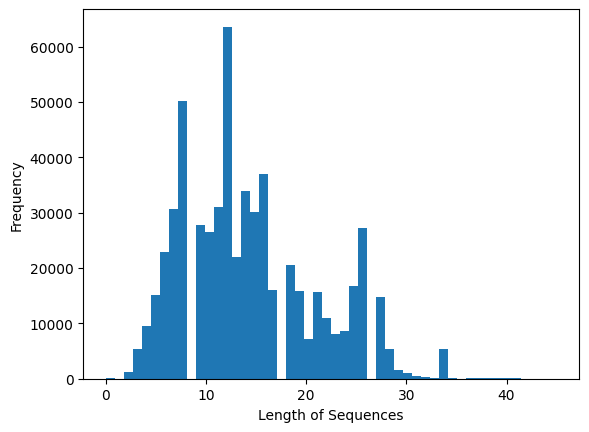

In [43]:
lengths = sample_df['encoded_1grams'].apply(len)

plt.hist(lengths, bins=50)
plt.xlabel('Length of Sequences')
plt.ylabel('Frequency')
plt.show()



In [44]:
# convert the data to a tensor and do the train test split
X_train, X_test, y_train, y_test = train_test_split(sample_df['padded_1grams'].values.tolist(), sample_df['default/class'].values, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# X is input and y is output
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([466959, 30])
torch.Size([466959])
torch.Size([116740, 30])
torch.Size([116740])


In [45]:
# our basic model, this is just a test the Q K V and word embedding are just with random value to calculate the encoded value. No backpropagation is involved.
vocab_size = len(vocab)  # vocabuary size
d_model = 32            # vector size
N = 6                    # num of encoder
h = 8                    # num of multi-head
d_ff = 64              # diamention of feedforward(the neuron we have in feedforward)
max_len = 35             # max len
num_classes = 1          # number of classes of output
dropout = 0.1            # 10% will be dropped

# initiate a object
dga_detector = DGA_Dector(vocab_size, d_model, N, h, d_ff, max_len, num_classes, dropout)
print(dga_detector)

DGA_Dector(
  (src_embed): InputEmbeddings(
    (embedding): Embedding(40, 32)
  )
  (src_pos): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (self_attention_block): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=32, out_features=32, bias=True)
          (w_k): Linear(in_features=32, out_features=32, bias=True)
          (w_v): Linear(in_features=32, out_features=32, bias=True)
          (w_o): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (linear_1): Linear(in_features=32, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=64, out_features=32, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnection(
            (dropout): Dro

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [47]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.


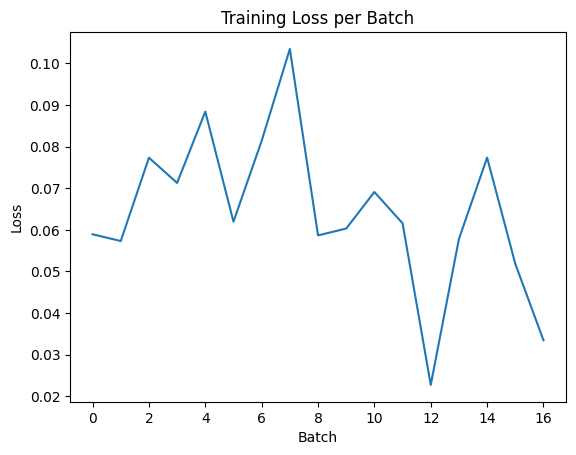

Epoch 17/50, Loss: 0.13394945602806074


KeyboardInterrupt: 

In [48]:
# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(dga_detector.parameters(), lr=0.001)
num_epochs = 50  # number of epochs
batch_size = 32  # batch size

# move the model to the device (GPU)
dga_detector.to(device)
loss_values = []
# training loop
for epoch in range(num_epochs):
    dga_detector.train()  # training mode
    running_loss = 0.0

    for i in range(0, len(X_train), batch_size):
      # getting a batch of data
      batch_X = X_train[i:i + batch_size].to(device)
      batch_y = y_train[i:i + batch_size].to(device)

      # create mask based on batch_X
      src_mask = (batch_X != 0).int().to(device)

      # forward pass
      output = dga_detector(batch_X, src_mask)

      # calculate loss output = loss(m(input), target)
      loss = loss_fn(output, batch_y.float().unsqueeze(1))

      # zero gradients
      optimizer.zero_grad()

      # backward pass
      loss.backward()

      # update weights
      optimizer.step()

      # accumulate running loss
      running_loss += loss.item()


    # print average loss for each epoch

    clear_output(wait=True)
    loss_values.append(loss.item())
    plt.plot(loss_values)
    plt.title('Training Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / (len(X_train) // batch_size)}")


In [49]:
# Evaluation mode
dga_detector.eval()
all_pred = []
all_true = []

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch_X = X_test[i:i + batch_size].to(device)
        batch_y = y_test[i:i + batch_size].to(device)

        src_mask = create_mask(batch_X.tolist())
        src_mask = torch.tensor(src_mask).int().to(device)

        output = dga_detector(batch_X, src_mask)

        predicted = (output > 0.5).float()

        predicted = predicted.squeeze().cpu().numpy()
        if predicted.ndim == 0:
            predicted = np.array([predicted])

        all_pred.extend(predicted)
        all_true.extend(batch_y.cpu().numpy())

conf_matrix = confusion_matrix(all_true, all_pred)

print("Confusion Matrix:")
print(conf_matrix)

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Confusion Matrix:
[[37371  2628]
 [ 3517 73224]]
Test Accuracy: 94.74%


In [50]:
torch.save(dga_detector.state_dict(), "dga_detector_model_v2.1.model")

Using a 20% dataset

==============================
V2.1:

# our basic model, this is just a test the Q K V and word embedding are just with random value to calculate the encoded value. No backpropagation is involved.
vocab_size = len(vocab)  # vocabuary size
d_model = 32            # vector size
N = 6                    # num of encoder
h = 8                    # num of multi-head
d_ff = 64              # diamention of feedforward(the neuron we have in feedforward)
max_len = 35             # max len
num_classes = 1          # number of classes of output
dropout = 0.1            # 10% will be dropped

# initiate a object
dga_detector = DGA_Dector(vocab_size, d_model, N, h, d_ff, max_len, num_classes, dropout)
print(dga_detector)

Confusion Matrix:
[[37371  2628]
 [ 3517 73224]]
Test Accuracy: 94.74%

==============================

Using a 0.005% dataset

===============================

V1.2 :

batch_size: 1  
vocab_size = len(vocab)  # vocabulary size  
d_model = 4              # vector size  
N = 6                    # number of encoders  
h = 2                    # number of multi-heads  
d_ff = 10                # dimension of feedforward (the neurons in the feedforward layer)  
max_len = 30             # max sequence length  
num_classes = 1          # number of output classes  
dropout = 0.1            # 10% dropout rate  
Confusion Matrix:
[[ 764  238]
 [ 155 1762]]
Test Accuracy: 86.54%
**training time: 14min/ test time: 36s**

===============================

V1.1:

batch_size: 32  
vocab_size = len(vocab)  # vocabuary size
d_model = 6            # vector size
N = 6                    # num of encoder
h = 3                    # num of multi-head
d_ff = 10              # diamention of feedforward(the neuron we have in feedforward)
max_len = 30             # max len
num_classes = 1          # number of classes of output
dropout = 0.1            # 10% will be dropped
**accuracy: 81.53%**  
**[[ 801  201]**

**[ 289 1628]]**
**training time: 48s/ test time: 2s**

===============================


In [ ]:
print(torch.ones_like(X[0]))
print(X[0])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([14, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
